In [98]:
import matplotlib.pyplot as plt
import numpy as np
import scipy
import torch
from botorch.acquisition import UpperConfidenceBound
from botorch.fit import fit_gpytorch_model
from botorch.models import SingleTaskGP
from botorch.optim import optimize_acqf
from botorch.utils import standardize
from gpytorch.mlls import ExactMarginalLogLikelihood

In [99]:
def calculate_target_function(points):
    result = []
    for pnt in points:
        try:
            x = pnt[0]
        except:
            x = pnt.item()
        fn = np.exp(-(x - 2)**2) + np.exp(-(x - 6)**2/10) + 1 / (x**2 + 1)
        # f(x) = e^(-(x - 2)^2) + e^((-(x - 6)^2) / 10) + (1 / (x^2+1))
        result.append(fn)
    return torch.tensor(result).unsqueeze(-1)

In [100]:
def BO_procedure(train_X, train_Y, bounds):
    gp = SingleTaskGP(train_X, train_Y)
    mll = ExactMarginalLogLikelihood(gp.likelihood, gp)
    fit_gpytorch_model(mll)

    UCB = UpperConfidenceBound(gp, beta=10)  # higher beta means more exploration (example: 10000)

    candidate, acq_value = optimize_acqf(
        UCB, bounds=bounds, q=1, num_restarts=5, raw_samples=20,
    )

    candidate_y = calculate_target_function(candidate)
    print(f'    Candidate: ({candidate[0][0].numpy()}, {candidate_y[0][0].numpy()})')

    new_X = torch.cat([train_X, candidate])
    new_Y = torch.cat([train_Y, candidate_y])

    return gp, new_X, new_Y

In [101]:
def plot(model, train_X, train_Y, bounds):
    from matplotlib import pyplot as plt
    %matplotlib inline

    target_x = torch.linspace(bounds[0][0], bounds[1][0], 101)
    target_y = calculate_target_function(target_x)

    # Initialize plot
    f, ax = plt.subplots(1, 1, figsize=(6, 4))
    # test model on 101 regular spaced points on the interval [0, 1]
    test_X = torch.linspace(bounds[0][0], bounds[1][0], 101)
    # no need for gradients
    with torch.no_grad():
        # plot target function (inclusion of noise decreases accuracy)
        ax.plot(target_x.cpu().numpy(), target_y.cpu().numpy(), 'r')

        # compute posterior
        posterior = model.posterior(test_X)
        # Get upper and lower confidence bounds (2 standard deviations from the mean)
        lower, upper = posterior.mvn.confidence_region()
        # Plot training points as black stars
        ax.plot(train_X.cpu().numpy(), train_Y.cpu().numpy(), 'k*')
        # Plot posterior means as blue line
        ax.plot(test_X.cpu().numpy(), posterior.mean.cpu().numpy(), 'b')
        # Shade between the lower and upper confidence bounds
        ax.fill_between(test_X.cpu().numpy(), lower.cpu().numpy(), upper.cpu().numpy(), alpha=0.5)

    ax.legend(['Target Function', 'Observed Data', 'Mean', 'Confidence'])
    plt.tight_layout()

Executing Iteration 1:
    Candidate: (8.130840301513672, 0.6499530673027039)
Executing Iteration 2:
    Candidate: (8.665726661682129, 0.5044859647750854)
Executing Iteration 3:
    Candidate: (7.584621906280518, 0.795028805732727)
Executing Iteration 4:
    Candidate: (6.965485572814941, 0.9311912655830383)
Executing Iteration 5:
    Candidate: (6.2552900314331055, 1.0184237957000732)
Executing Iteration 6:
    Candidate: (5.544634819030762, 1.0109843015670776)
Executing Iteration 7:
    Candidate: (4.899425506591797, 0.9261382818222046)
Executing Iteration 8:
    Candidate: (2.4008543491363525, 1.2731926441192627)
Executing Iteration 9:
    Candidate: (1.0802360773086548, 0.9795147180557251)
Executing Iteration 10:
    Candidate: (3.296694755554199, 0.7518991827964783)
Executing Iteration 11:
    Candidate: (1.8484567403793335, 1.3821399211883545)
Executing Iteration 12:
    Candidate: (2.064446210861206, 1.3983896970748901)
Executing Iteration 13:
    Candidate: (-0.344600051641464

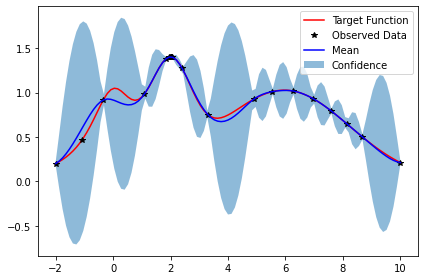

In [102]:
NUM_ITERATIONS = 20
BOUNDS = torch.tensor([[-2.0], [10.0]])
train_X = torch.linspace(BOUNDS[0][0], BOUNDS[1][0], 2).unsqueeze(1)
train_Y = calculate_target_function(train_X)
for i in range(NUM_ITERATIONS):
    print(f'Executing Iteration {i + 1}:')
    model, train_X, train_Y = BO_procedure(train_X, train_Y, BOUNDS)

plot(model, train_X, train_Y, BOUNDS)